In [1]:

with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/src.py') as f:
    exec(f.read())
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/tcga_src.py') as f:
    exec(f.read())
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zi=False

/home/jislam/.local/lib/python3.10/site-packages/gosip/__init__.py:5: FutureWarning: In the future `np.ulong` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'ulong'):


In [2]:
sns.set(style="whitegrid")

min_optuna=10
hyperparam_epochs=200 #max per trial
hyperparam_trials=100 #number of trials for each model.
n_top_genes=2000
burn_in=10
burn_in_cbnn=5
patience=10
patience_cbnn=10
k=100
validation_ratio=0.2

main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_02/analyses/maxabsversions/"
filter_by="cancerxrisk"
category_labels=[filter_by] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.
#group_a=["High Risk"]
#group_b=["Low Risk"]
shared_filter =None
analysis_set="pancancer_tcga"
###########################################
# MUST BE SPECIFIED FOR EACH INQUIRY.
# SEE BOTTOM OF SCRIPT. NEAR THE BOTTOM: 
# when generating the full reports, you 
# will need to specify the following 
# parameters manually. For example.
# To automate this, using group_a
# and group b, with shared_filter
# set to none. Details on the filters
# below.
##########################################
# shared_filter = ["sex=female"] 
# EXACT LABEL in adata.one_hot_encoded.columns.
# If set to None, will not filter. if you want 
# to specify a particular subset of cells, not 
# of the criteria of interest (in this case sex,
# or race would make sense if cell_disease is 
# what I'm interested in)
# filter_criteria_start = ["Tumor"]
# SMART LABEL: searches for the substring in 
# adata.one_hot_encoded.columns. can grab all 
# Tumor with "Tumor" or the specific interaction 
# with ->["cell_disease=beta cell_Tumor"] 
# filter_criteria_goal =["Normal"]
# SMART LABEL: same idea.
########################################




outdir=analysis_set.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/data/tcga_data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena',sep="\t")
rnaseq.rename(columns={'sample': 'gene_id'}, inplace=True)
#rnaseq = filter_primary_tumors(rnaseq)
rnaseq = filter_smallest_sample(rnaseq)
clinical =  pd.read_excel('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/data/tcga_data/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=None)
clinical=clinical['TCGA-CDR'].copy()


adata=build_anndata(rnaseq=rnaseq,clinical=clinical)

adata.obs['ajcc_simplified']=categorize_ajcc_risk(adata.obs['ajcc_pathologic_tumor_stage'])




adata.obs['ajcc_simplified']=categorize_ajcc_risk(adata.obs['ajcc_pathologic_tumor_stage'])
to_filter=group_by_both_obs(adata,"type",'ajcc_simplified')
to_keep=to_filter[~((to_filter["_High Risk"] < 10) | 
          (to_filter["_Low Risk"]  <10) | 
          (to_filter[["_High Risk", "_Low Risk"]].max(axis=1) / to_filter[["_High Risk", "_Low Risk"]].min(axis=1) > 100))
         ].index

adata = adata[adata.obs['type'].isin(to_keep)].copy()
adata = adata[adata.obs['ajcc_simplified'].isin(['_High Risk','_Low Risk'])].copy()
adata.obs["cancerxrisk"]=adata.obs["type"].astype(str)  + adata.obs["ajcc_simplified"].astype(str)
clear_output(wait=True)
adata.obs['cancerxrisk'].value_counts()



import scanpy as sc
import matplotlib.pyplot as plt

# Step 1: Run PCA
sc.pp.pca(adata, n_comps=50)
print("PCA completed.")

# Step 2: Compute neighborhood graph
sc.pp.neighbors(adata, n_pcs=30)  # Use the first 30 principal components
print("Nearest-neighbor graph computed.")

# Step 3: Compute UMAP
sc.tl.umap(adata)
print("UMAP embedding completed.")
group_by_both_obs(adata,"type",'ajcc_simplified')


# Step 4: Plot UMAP, colored by 'ajcc_simplified'
sc.pl.umap(adata, color=['ajcc_simplified','type'], frameon=False, title="UMAP colored by AJCC Risk Category")


sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

# Step 2: Subset to keep only HVGs
adata = adata[:, adata.var['highly_variable']].copy()

# Optional: Check how many genes were selected
print(f" Selected {adata.n_vars} highly variable genes.")
clear_output()
one_hot_labels, num_categories= gosip.one_hot_encode_combinations(adata.obs, category_labels)
adata.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:


group_by_both_obs(adata,"type",'ajcc_simplified')

ajcc_simplified,_High Risk,_Low Risk
type,,
BRCA,889,181
CHOL,17,19
COAD,364,74
ESCA,143,18
HNSC,418,27
KICH,45,20
KIRC,261,267
KIRP,87,171
LIHC,175,171


/tmp/ipykernel_80399/924717147.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


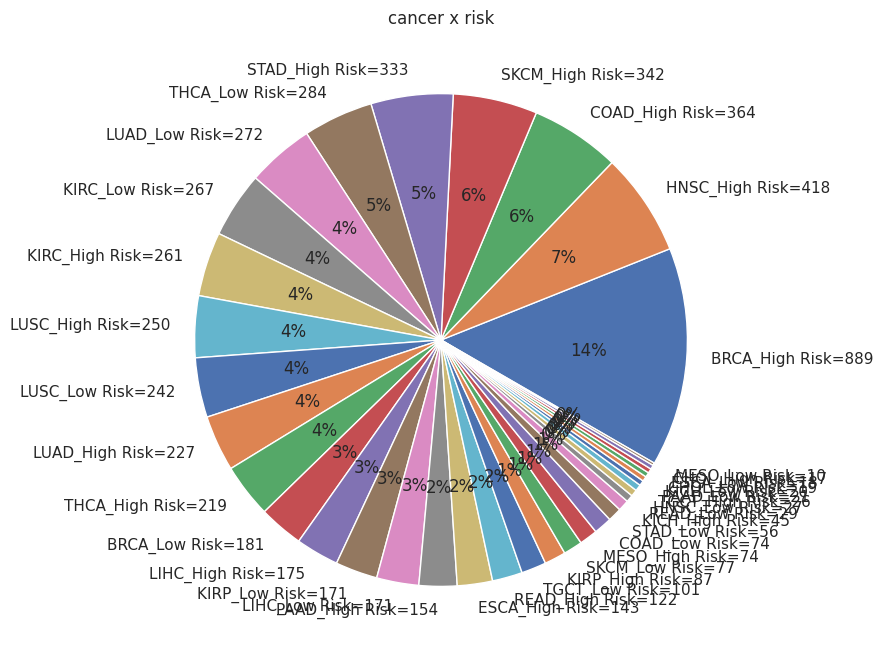

/tmp/ipykernel_80399/924717147.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


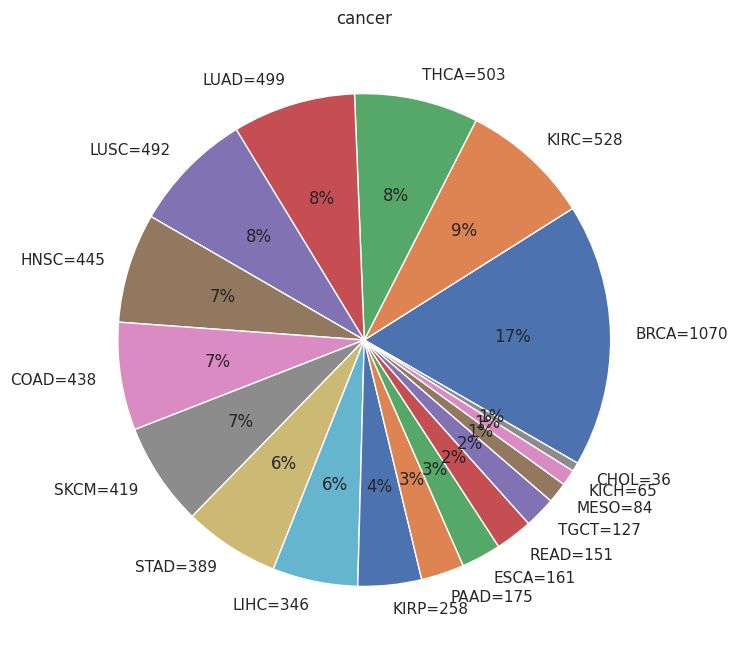

/tmp/ipykernel_80399/924717147.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]


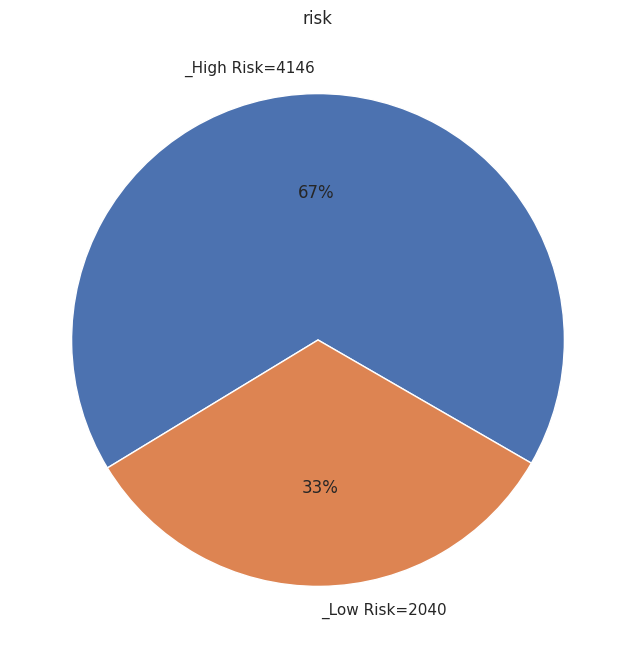

In [4]:
# Extract the column data
column_data = adata.obs[filter_by]

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('cancer x risk')
plt.show()


column_data = adata.obs['type']

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('cancer')
plt.show()


column_data = adata.obs['ajcc_simplified']

# Count the occurrences of each unique value
value_counts = column_data.value_counts()
value_counts.index=[ value_counts.index[v]+"="+str(value_counts[v])  for v in range(value_counts.shape[0])]
# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%.0f%%', startangle=-30)
plt.title('risk')
plt.show()

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.8], width_ratios=[1, 1], figure=fig)

# Function to add labels on bars
def add_bar_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(v + max(values) * 0.02, i, str(v), va='center', fontsize=10)  # Shift label slightly to the right

# Function to add subplot labels (A, B, C)
def add_subplot_label(ax, label,x_pos=0.02,y_pos=0.99):
    ax.text(x_pos,y_pos, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# --- PLOT 1: UMAP (Spanning the full first row) ---
ax1 = fig.add_subplot(gs[0, :])  # Full row for UMAP
sc.pl.umap(adata, color=["cell_disease"], ax=ax1, show=False)
ax1.set_title("UMAP of Cell x Disease")
add_subplot_label(ax1, "A",x_pos=-0.03,y_pos=1.06)  # Add label "A"

# --- PLOT 2: Bar Chart for Control State ---
ax2 = fig.add_subplot(gs[1, 0])
column_data = adata.obs.loc[adata.obs['disease_state'] == "Control", 'cell_type']
value_counts = column_data.value_counts(ascending=True)

sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax2, palette="Blues_r")
ax2.set_title("Control State: Cell Type Distribution")
ax2.set_xlabel("Cell Count")
ax2.set_ylabel("Cell Type")
add_bar_labels(ax2, value_counts.values)
add_subplot_label(ax2, "B",x_pos=-0.06,y_pos=1.06)  # Add label "B"

# --- PLOT 3: Bar Chart for T2D State ---
ax3 = fig.add_subplot(gs[1, 1])
column_data = adata.obs.loc[adata.obs['disease_state'] == "T2D", 'cell_type']
value_counts = column_data.value_counts(ascending=True)

# Ensure the last element is removed safely
if value_counts.shape[0] > 1:
    value_counts = value_counts

sns.barplot(x=value_counts.values, y=value_counts.index.str.replace("_", " "), ax=ax3, palette="Reds_r")
ax3.set_title("T2D State: Cell Type Distribution")
ax3.set_xlabel("Cell Count")
ax3.set_ylabel("Cell Type")
add_bar_labels(ax3, value_counts.values)
add_subplot_label(ax3, "C",x_pos=-0.06,y_pos=1.06)  # Add label "C"

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(f'{main_path}{single_cell_data}/hpapnb-developmental-merge.png')

In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

55742

In [6]:


import gc
torch.cuda.empty_cache()
gc.collect()
#simulation_results={}
min_layer_size_star=int(adata.shape[1]*2/16)
max_layer_size_star=int(adata.shape[1]*8/16)


min_layer_size_oracle=int(adata.shape[1]*2/16)
max_layer_size_oracle=int(adata.shape[1]*8/16)

min_layer_size_prop=int(adata.shape[1]*2/16)
max_layer_size_prop=int(adata.shape[1]*8/16)


bsize=1024

from copy import deepcopy

category_labels=[filter_by] 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



###########################################################################################
###########################################################################################
#### Stargan
###########################################################################################
###########################################################################################         
study = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_stargan.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_stargan_SIMULATION_"+"_main.db",
                            load_if_exists=True)


start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_stargan(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_star,max_layer_size=max_layer_size_star, bsize=bsize,burn_in=burn_in,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))

# Get the best hyperparameters
best_params = study.best_params

stargan_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'layer_nodes_discriminator': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'critics': 3,

    "dropout_rate":best_params["dropout_rate"]
}

###########################################################################################
###########################################################################################
#### Oracle
###########################################################################################
###########################################################################################


study = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_oracle.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_oracle_SIMULATION_"+"main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_oracle(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_oracle,max_layer_size=max_layer_size_oracle, bsize=bsize,burn_in=burn_in), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
oracle_hyperparam = {'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'dropout_rate_d': best_params['disc_dropout_rate']
}
   
###########################################################################################
###########################################################################################
#### Propagator
###########################################################################################
###########################################################################################

study = optuna.create_study(storage="sqlite:///"+outdir+"/"+analysis_set.replace(" ","_")+"_SIMULATION_propagator.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=analysis_set.replace(" ", "_")+"_propagator_SIMULATION_"+"main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_propagator(trial, adata,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_prop,max_layer_size=max_layer_size_prop, bsize=bsize,burn_in=burn_in,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

propagator_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'dropout_rate_g': best_params['gen_dropout_rate'],
    'latent_dim':best_params['latent'],
    'beta':float(best_params['beta'])
    
}


shared_filter = None
filter_criteria_start = ["start"]
filter_criteria_goal  = ["goal"]



#################################################
###Refit models with new zero-inflation
#################################################
train_adata,val_adata=  split_and_maxabs_scale_adata(adata,validation_ratio)
train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])

loss_weights=[1,1,10,10,10]
stargan = gosip.StarGAN(input_dim=adata.shape[1],
                  num_domains=[adata.one_hot_labels.shape[1]],
                  device = device,
                  learning_rate = stargan_hyperparam['learning_rate'],
                  layer_g = stargan_hyperparam['layer_nodes_generator'],
                  layer_d = stargan_hyperparam['layer_nodes_discriminator'],
                  critics = stargan_hyperparam['critics'],
                  lambda_adv=loss_weights[0],
                  lambda_cls=loss_weights[1],
                  lambda_rec=loss_weights[2],
                  dropout_rate=stargan_hyperparam["dropout_rate"],zi=zi)
stargan.train( dataloader=train_dataloader,val_loader=val_dataloader, num_epochs=2000,patience=patience,burn_in=burn_in,verbose=True)
stargan.G.eval()
stargan.D.eval()
torch.cuda.empty_cache()
oracle = gosip.Oracle(input_dim=adata.shape[1],
         num_domains=num_categories,
         device = device,
         learning_rate = oracle_hyperparam['learning_rate'],
         layer_d = oracle_hyperparam['layer_nodes'],
         drpt_d = oracle_hyperparam['dropout_rate_d'])
oracle.train(dataloader=train_dataloader, val_loader=val_dataloader, num_epochs=2000,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False)
oracle.D.eval()
torch.cuda.empty_cache()

propagator = gosip.Propagator(input_dim=train_adata.shape[1],
                 num_domains=num_categories,
                 device = device,
                 learning_rate = propagator_hyperparam['learning_rate'],
                 layer_g = propagator_hyperparam['layer_nodes_generator'],
                 drpt_g = propagator_hyperparam['dropout_rate_g'],
                 latent_dim=propagator_hyperparam['latent_dim'],zi=zi)
loss_fn = gosip.BtcvaeLoss(n_data=train_adata.shape[0], alpha=1.0, beta=propagator_hyperparam['beta'], gamma=1.0,zi=zi)
propagator.train(dataloader=train_dataloader, val_loader=val_dataloader,
                 num_epochs=2000,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False,
                 loss_fn=loss_fn)



propagator.G.eval()
torch.cuda.empty_cache()




clear_output(wait=True)



Epoch [37/2000]
  Training Loss: -10.92, Validation Loss: -45.41
  Seconds/Epoch: 0.12, No Improvement: 9
Stopping early at epoch 37


In [7]:
train_adata.obs

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_code,ajcc_simplified,cancerxrisk
4380,4166,TCGA-BP-4756,KIRC,62.0,FEMALE,ASIAN,Stage I,[Not Applicable],Kidney Clear Cell Renal Carcinoma,G2,...,0.0,374.0,NaN,NaN,0.0,374.0,NaN,01,_Low Risk,KIRC_Low Risk
1556,3615,TCGA-D6-6825,HNSC,73.0,MALE,WHITE,Stage I,Stage III,Head & Neck Squamous Cell Carcinoma,G2,...,0.0,491.0,0.0,491.0,0.0,491.0,NaN,01,_Low Risk,HNSC_Low Risk
6747,10210,TCGA-ET-A25R,THCA,51.0,FEMALE,WHITE,Stage III,[Not Applicable],Thyroid Papillary Carcinoma - Tall Cell (>= 50...,[Not Available],...,0.0,1930.0,0.0,1930.0,0.0,1930.0,NaN,01,_High Risk,THCA_High Risk
4530,4317,TCGA-CJ-4923,KIRC,63.0,FEMALE,WHITE,Stage IV,[Not Applicable],Kidney Clear Cell Renal Carcinoma,G4,...,1.0,572.0,NaN,NaN,1.0,25.0,NaN,01,_High Risk,KIRC_High Risk
3536,6360,TCGA-21-A5DI,LUSC,77.0,MALE,WHITE,Stage IA,[Not Applicable],Lung Squamous Cell Carcinoma,[Not Available],...,0.0,979.0,0.0,979.0,0.0,979.0,NaN,01,_Low Risk,LUSC_Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,1263,TCGA-D8-A1XF,BRCA,45.0,FEMALE,WHITE,Stage IIA,[Not Applicable],Infiltrating Ductal Carcinoma,[Not Available],...,0.0,463.0,NaN,NaN,0.0,463.0,NaN,01,_High Risk,BRCA_High Risk
7934,6844,TCGA-LK-A4NW,MESO,60.0,MALE,WHITE,Stage IV,[Not Applicable],Diffuse malignant mesothelioma - NOS,[Not Available],...,1.0,546.0,NaN,NaN,1.0,546.0,NaN,01,_High Risk,MESO_High Risk
7969,6879,TCGA-TS-A7OY,MESO,62.0,MALE,WHITE,Stage IV,[Not Applicable],Epithelioid mesothelioma,[Not Available],...,NaN,255.0,NaN,NaN,0.0,255.0,NaN,01,_High Risk,MESO_High Risk
8522,1912,TCGA-3X-AAVC,CHOL,72.0,FEMALE,WHITE,Stage I,[Not Applicable],Cholangiocarcinoma; hilar/perihilar,G3,...,0.0,709.0,0.0,709.0,0.0,709.0,NaN,01,_Low Risk,CHOL_Low Risk


In [8]:
import gc
torch.cuda.empty_cache()
gc.collect()
with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_02/extra_scripts/cbnn_src_no_centrality.py') as f:
    exec(f.read())
torch.cuda.empty_cache()
gc.collect()
# Check if GPU is available
### --- PARAMETER CONFIGURATION --- ###
time_var = "PFI.time"
event_var = "PFI"
weight_var = "cancerxrisk"
label = "pan_tcga"

min_layer_size = int(adata.shape[1]*2/16)
max_layer_size = int(adata.shape[1]*8/16)

fit_epochs = 2000
# Feature scaling ratio
ratio = 100

### --- RUN HYPERPARAMETER STUDY --- ###
study = run_study_cbnn(
    adata,
    time_var=time_var,
    event_var=event_var,
    weight_var=weight_var,
    min_optuna=min_optuna,
    layer_low=min_layer_size,
    layer_high=max_layer_size,
    hyperparam_epochs=hyperparam_epochs,
    label=label,
    val_size=validation_ratio,
    hyperparam_trials=hyperparam_trials,
    burn_in=burn_in_cbnn,
    patience=patience_cbnn  
)

best_params = study.best_params

cbnn_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['lr'],
    'layer_nodes': [best_params["layer0"], best_params["layer1"], best_params["layer2"]],
    'dropout_rate': best_params['dropout']
}

### --- DATA PREPARATION --- ###
cb_df_train, cb_df_val, max_time, train_means, train_sds, pre_cb_data = process_pre_split_adatas(train_adata,val_adata,
                                                                                                 time_var=time_var,
                                                                                                 event_var=event_var,
                                                                                                 weight_var=weight_var,
                                                                                                 ratio=100,
                                                                                                 pre_cb_data=True)

features = cb_df_train.columns[:-4].copy()

### --- PREPARE MODEL --- ###
cbnn_prep = prep_cbnn(
    features=features,
    data=cb_df_train,
    time_var="time",
    event_var="status",
    ratio=ratio,
    comp_risk=False,
    layers=cbnn_hyperparam['layer_nodes'],
    dropout=cbnn_hyperparam['dropout_rate'],
    lr=cbnn_hyperparam['learning_rate']
)

### --- FIT FINAL MODEL --- ###
cbnn_fit = fit_hazard_optuna(
    cbnn_prep,
    epochs=fit_epochs,
    batch_size=int(cbnn_hyperparam['batch_size']),
    val_data=cb_df_val,
    burn_in=burn_in_cbnn,
    patience=patience_cbnn  
)

### --- FINAL DATA SPLIT --- ###
train_data = pre_cb_data['pre_cb_train'].copy()
test_data = pre_cb_data['pre_cb_val'].copy()


Epoch 33/2000 | Val Loss: 0.0548 | Patience: 9
Epoch 33 took 1.60 sec


Early stopping at epoch 34


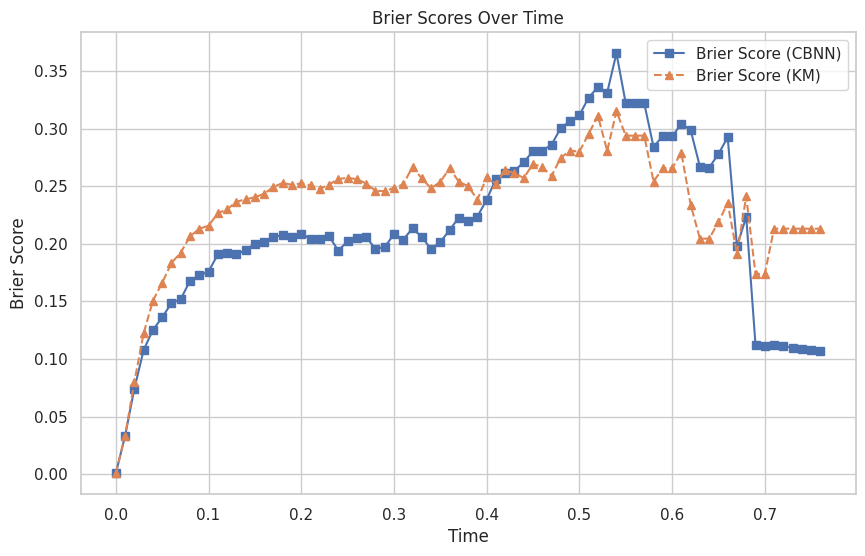

In [9]:
### --- FINAL DATA SPLIT --- ###
train_data = pre_cb_data['pre_cb_train'].copy()
test_data = pre_cb_data['pre_cb_val'].copy()
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score



# Convert to structured array
train_surv = np.array([(e, t) for e, t in zip(train_data['status'], train_data['time'])],
                         dtype=[('event', 'bool'), ('time', 'f8')])
test_surv = np.array([(e, t) for e, t in zip(test_data['status'], test_data['time'])],
                         dtype=[('event', 'bool'), ('time', 'f8')])



times=[p/100 for p in range(0,int(test_data['time'].max()*100))]
cumulative_incidences,times=cu_inc_cbnn(cbnn_fit, times=times, x_test=torch.tensor(test_data[features].values, dtype=torch.float32))
times=times.cpu().detach()
survival_estimates_cbnn=1-cumulative_incidences
survival_estimates_cbnn=survival_estimates_cbnn.cpu().detach()
times, score_cbnn = brier_score(train_surv, test_surv, survival_estimates_cbnn, times)
score_cbnn


#est = CoxPHSurvivalAnalysis(ties="efron").fit(train_data[features], train_surv)
#cox_survs = est.predict_survival_function(test_data[features])
#cox_preds = [fn(times) for fn in cox_survs]
#times, score_cox = brier_score(train_surv, test_surv, cox_preds, times)
#score_cox


from lifelines import KaplanMeierFitter
import numpy as np

# 1. Fit KM on the test set
kmf = KaplanMeierFitter()
kmf.fit(durations=test_data['time'], event_observed=test_data['status'])

# 2. Evaluate KM survival probabilities at the desired time points
km_survival_probs = kmf.predict(times).values  # shape: (n_times,)

# 3. Repeat KM predictions for all test samples
n_samples = len(test_data)
km_preds = np.tile(km_survival_probs, (n_samples, 1))  # shape: (n_samples, n_times)

# 4. Compute Brier score using these predictions
times_km, score_km = brier_score(train_surv, test_surv, km_preds, times)


# Add KM benchmark to plot
plt.figure(figsize=(10, 6))
#plt.plot(times, score_cox, label='Brier Score (Cox)', marker='o')
plt.plot(times, score_cbnn, label='Brier Score (CBNN)', marker='s')
plt.plot(times, score_km, label='Brier Score (KM)', marker='^', linestyle='--')

plt.title('Brier Scores Over Time')
plt.xlabel('Time')
plt.ylabel('Brier Score')
plt.legend()
plt.grid(True)
plt.show()


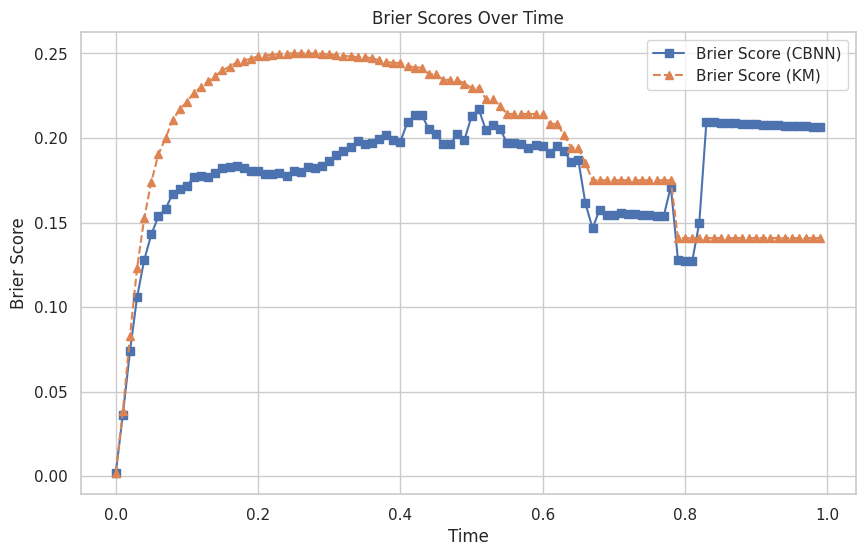

In [10]:
# Option B: if you want to keep track of where each row came from
combined_data = pd.concat([
    train_data.assign(split='train'),
    test_data.assign(split='test')
], ignore_index=True)

train_data = combined_data.copy()
test_data = combined_data.copy()

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score



# Convert to structured array
train_surv = np.array([(e, t) for e, t in zip(train_data['status'], train_data['time'])],
                         dtype=[('event', 'bool'), ('time', 'f8')])
test_surv = np.array([(e, t) for e, t in zip(test_data['status'], test_data['time'])],
                         dtype=[('event', 'bool'), ('time', 'f8')])



times=[p/100 for p in range(0,int(test_data['time'].max()*100))]
cumulative_incidences,times=cu_inc_cbnn(cbnn_fit, times=times, x_test=torch.tensor(test_data[features].values, dtype=torch.float32))
times=times.cpu().detach()
survival_estimates_cbnn=1-cumulative_incidences
survival_estimates_cbnn=survival_estimates_cbnn.cpu().detach()
times, score_cbnn = brier_score(train_surv, test_surv, survival_estimates_cbnn, times)
score_cbnn


#est = CoxPHSurvivalAnalysis(ties="efron").fit(train_data[features], train_surv)
#cox_survs = est.predict_survival_function(test_data[features])
#cox_preds = [fn(times) for fn in cox_survs]
#times, score_cox = brier_score(train_surv, test_surv, cox_preds, times)
#score_cox


from lifelines import KaplanMeierFitter
import numpy as np

# 1. Fit KM on the test set
kmf = KaplanMeierFitter()
kmf.fit(durations=test_data['time'], event_observed=test_data['status'])

# 2. Evaluate KM survival probabilities at the desired time points
km_survival_probs = kmf.predict(times).values  # shape: (n_times,)

# 3. Repeat KM predictions for all test samples
n_samples = len(test_data)
km_preds = np.tile(km_survival_probs, (n_samples, 1))  # shape: (n_samples, n_times)

# 4. Compute Brier score using these predictions
times_km, score_km = brier_score(train_surv, test_surv, km_preds, times)


# Add KM benchmark to plot
plt.figure(figsize=(10, 6))
#plt.plot(times, score_cox, label='Brier Score (Cox)', marker='o')
plt.plot(times, score_cbnn, label='Brier Score (CBNN)', marker='s')
plt.plot(times, score_km, label='Brier Score (KM)', marker='^', linestyle='--')

plt.title('Brier Scores Over Time')
plt.xlabel('Time')
plt.ylabel('Brier Score')
plt.legend()
plt.grid(True)
plt.show()


Iter 100/100 done. — elapsed 1685.1s — ETA 0.0s


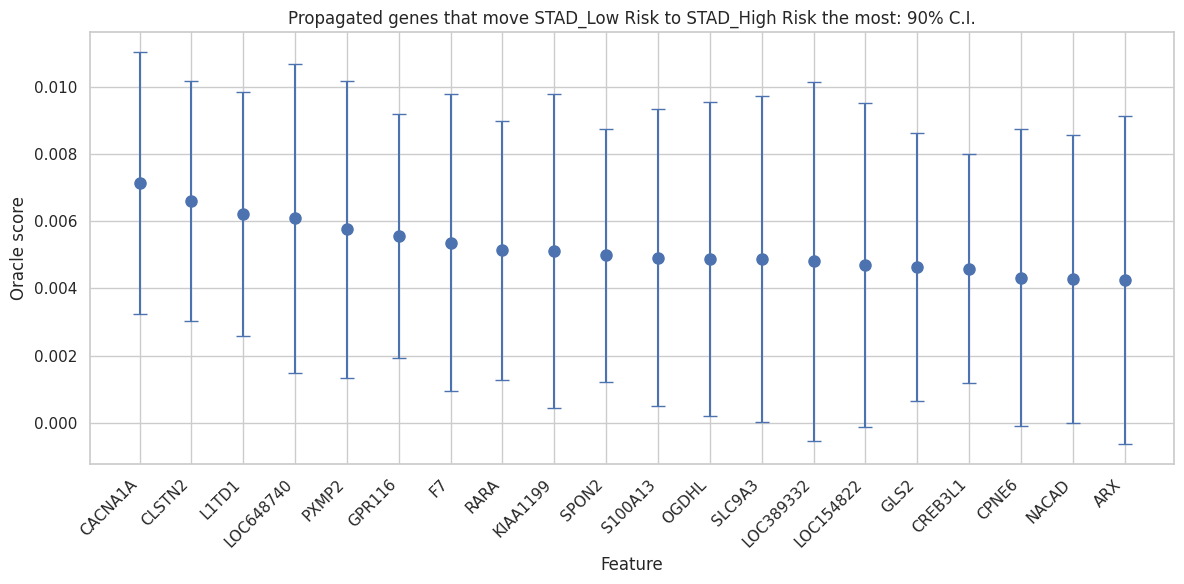

140510.17137360573


In [11]:

# 1. Concatenate the AnnData objects (this aligns var‐axes, etc.)
processed_adata = ad.concat(
    [train_adata, val_adata],
    join='inner',            # only keep genes present in both
    label='split',           # name of the new obs column
    keys=['train', 'val'],   # values in combined_adata.obs['split']
    fill_value=0
)

# 2. Stitch the one_hot_labels together
combined_labels = pd.concat(
    [train_adata.one_hot_labels, val_adata.one_hot_labels],
    axis=0
)
# 3. Re‐order them to match the new obs order, then attach back
combined_labels = combined_labels.reindex(processed_adata.obs_names)
processed_adata.one_hot_labels = combined_labels.copy()
unique_cancers=adata.obs['type'].unique()#.sort_values()
start_time=time.time()
for cancer in unique_cancers:
    group_high= [cancer+"_High Risk"]
    group_low = [cancer+"_Low Risk"]

    shared_filter = None
    
    perturbation_metrics,accuracy,result_path=full_report_cbnn(adata=processed_adata,
                                                               stargan=stargan,oracle=oracle,propagator=propagator,cbnn=cbnn_fit,
                                                               shared_filter=shared_filter,
                                                               filter_criteria_start=group_high,filter_criteria_goal=group_low,
                                                               device=device,num_categories=num_categories,category_labels=category_labels,
                                                               main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                                               umap=False,oracle_performance=True,alpha=0.5,times=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
                                                               sample_fraction=0.0001,k=k)
    
    
    perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
    perturbation_metrics_start_to_goal=perturbation_metrics.copy()
    perturbation_metrics,accuracy,result_path=full_report_cbnn(adata=processed_adata,
                                                               stargan=stargan,oracle=oracle,propagator=propagator,cbnn=cbnn_fit,
                                                               shared_filter=shared_filter,
                                                               filter_criteria_start=group_low,filter_criteria_goal=group_high,
                                                               device=device,num_categories=num_categories,category_labels=category_labels,
                                                               main_path=main_path,outdir=outdir,top_n=20,percentile=0,
                                                               umap=False,oracle_performance=True,alpha=0.5,times=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
                                                               sample_fraction=0.0001,k=k)
    
    
    perturbation_metrics.to_csv(result_path+"summary_statistics.csv")
    perturbation_metrics_goal_to_start=perturbation_metrics.copy()

end_time=time.time()
print(end_time-start_time)

In [12]:
oracle_pval_col    = 'oracle_score_pval_acat_fdr'
survival_pval_col  = 'survival_score_pval_acat_fdr'
oracle_score_col   = 'oracle_score'
survival_score_col = 'survival_score'
pval_threshold     = 0.5

from statsmodels.stats.multitest import multipletests
unique_cancers=adata.obs['type'].unique()#.sort_values()

In [13]:
analysis_set="pancancer_tcga"
passing_sets_high_to_low={}
for cancer in unique_cancers:
    group_high=cancer+"_High Risk"
    group_low = cancer+"_Low Risk"

    file_path = os.path.join(
        main_path,
        analysis_set,
        f"from_{group_high}_to_{group_low}",
        "summary_statistics.csv"
    )
    
    # skip if it doesn't exist
    if not os.path.isfile(file_path):
        print(f"Warning: '{file_path}' not found—skipping {cancer}")tcga_pancancer_results-Copy1
        continue
    
    # load and filter
    temp = pd.read_csv(file_path)

    mask = (
        #(temp[oracle_pval_col]   < pval_threshold) &
        (temp[survival_pval_col] < pval_threshold) #&
        #(temp[oracle_score_col]  > 0) &
        #(temp[survival_score_col]> 0)
    )
    
    # apply it
    filtered = temp[mask]
    
    filtered
    gene_list = (
        filtered
        .apply(lambda row: f"{'+' if row['suggested_perturbation'] > 0 else '-'}{row['gene_name']}",
               axis=1)
        .tolist()
    )
    
    passing_sets_high_to_low[f'{cancer}']=gene_list 

/home/jislam/.local/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/jislam/.local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=Tru

/tmp/ipykernel_80399/3427288268.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


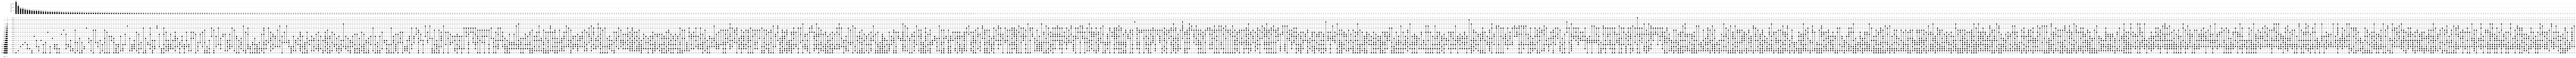

In [14]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

# your dict of lists (or sets)


# convert to the multi‐index format upsetplot wants
data = from_contents(passing_sets_high_to_low)

# plot!
up = UpSet(data,sort_by='cardinality',min_degree=1,   show_counts=True)
up.plot()
plt.tight_layout()
plt.show()


In [15]:
analysis_set="pancancer_tcga"
passing_sets_low_to_high={}
for cancer in unique_cancers:
    group_high=cancer+"_High Risk"
    group_low = cancer+"_Low Risk"
    file_path = os.path.join(
        main_path,
        analysis_set,
        f"from_{group_low}_to_{group_high}",
        "summary_statistics.csv"
    )
    
    # skip if it doesn't exist
    if not os.path.isfile(file_path):
        print(f"Warning: '{file_path}' not found—skipping {cancer}")
        continue
    
    # load and filter
    temp = pd.read_csv(file_path)
        # your variable names

    
    # build the mask
    mask = (
        #(temp[oracle_pval_col]   < pval_threshold) &
        (temp[survival_pval_col] < pval_threshold) &
        #(temp[oracle_score_col]  > 0) &
        (temp[survival_score_col]< 0)
    )
    
    # apply it
    filtered = temp[mask]
    
    filtered
    gene_list = (
        filtered
        .apply(lambda row: f"{'+' if row['suggested_perturbation'] > 0 else '-'}{row['gene_name']}",
               axis=1)
        .tolist()
    )
    
    passing_sets_low_to_high[f'{cancer}']=gene_list 

/home/jislam/.local/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/jislam/.local/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=Tru

/tmp/ipykernel_80399/1745361223.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


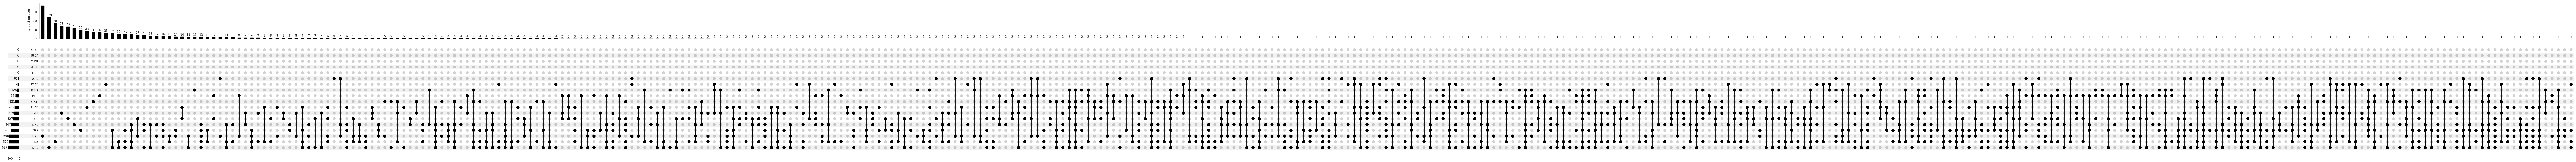

In [16]:
from upsetplot import from_contents, UpSet
import matplotlib.pyplot as plt

# your dict of lists (or sets)


# convert to the multi‐index format upsetplot wants
data = from_contents(passing_sets_low_to_high)

# plot!
up = UpSet(data,sort_by='cardinality',min_degree=1,   show_counts=True)
up.plot()
plt.tight_layout()
plt.show()
